In [2]:
import numpy as np
from numpy.polynomial import polynomial as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Ref: https://meshlogic.github.io/posts/jupyter/curve-fitting/parametric-curve-fitting/
# M. Grossman: Parametric Curve Fitting, The Computer Journal, 1971

In [3]:
class parametric_fitting:
    def __init__(self, polydeg = 6, max_iter = 20, eps = 1e-3, res = 100):
        #-------------------------------------------------------------------------------
        # Options for the approximation method
        #-------------------------------------------------------------------------------
        self.polydeg = polydeg   # Degree of polygons of parametric curve
        self.max_iter = max_iter         # Max. number of iterations
        self.eps = eps
        self.resolution = res

    def uniform_param(self, P):
        u = np.linspace(0, 1, len(P))
        return u
        
    def chordlength_param(self, P):
        u = self.generate_param(P, alpha=1.0)
        return u
        
    def centripetal_param(self, P):
        u = self.generate_param(P, alpha=0.5)
        return u
        
    def generate_param(self, P, alpha):
        n = len(P)
        u = np.zeros(n)
        u_sum = 0
        for i in range(1,n):
            u_sum += np.linalg.norm(P[i,:]-P[i-1,:])**alpha
            u[i] = u_sum
        
        return u/max(u)

    #-------------------------------------------------------------------------------
    # Find Minimum by Golden Section Search Method
    # - Return x minimizing function f(x) on interval a,b
    #-------------------------------------------------------------------------------
    def find_min_gss(self, f, a, b, eps=1e-4):
        
        # Golden section: 1/phi = 2/(1+sqrt(5))
        R = 0.61803399
        
        # Num of needed iterations to get precision eps: log(eps/|b-a|)/log(R)
        n_iter = int(np.ceil(-2.0780869 * np.log(eps/abs(b-a))))
        c = b - (b-a)*R
        d = a + (b-a)*R

        for i in range(n_iter):
            if f(c) < f(d):
                b = d
            else:
                a = c
            c = b - (b-a)*R
            d = a + (b-a)*R

        return (b+a)/2

    def iterative_param(self, P, u, fxcoeff, fycoeff, fzcoeff):
    
        # global iter_i
        u_new = u.copy()
        f_u = np.zeros(3)

        #--- Calculate approx. error s(u) related to point P_i
        def calc_s(u):
            f_u[0] = pl.polyval(u, fxcoeff)
            f_u[1] = pl.polyval(u, fycoeff)
            f_u[2] = pl.polyval(u, fzcoeff)

            s_u = np.linalg.norm(P[i]-f_u)
            return s_u
        
        #--- Find new values u that locally minimising the approximation error (excl. fixed end-points)
        for i in range(1, len(u)-1):
            
            #--- Find new u_i minimising s(u_i) by Golden search method
            u_new[i] = self.find_min_gss(calc_s, u[i-1], u[i+1])
            
            #--- Sample some values bewteen u[i-1] and u[i+1] to plot graph
            u_samp = np.linspace(u[i-1], u[i+1], 25)
            
            x = pl.polyval(u_samp, fxcoeff)
            y = pl.polyval(u_samp, fycoeff)
            z = pl.polyval(u_samp, fzcoeff)

            residual = P[i] - np.array([x,y,z]).T
            s_u_samp = [np.linalg.norm(residual[j]) for j in range(len(u_samp))]
        
        return u_new

    def run(self, P, return_error = False):
        n = P.shape[0]

        w = np.ones(n)           # Set weights for knot points
        w[0] = w[-1] = 1e6

        #-------------------------------------------------------------------------------
        # Init variables
        #-------------------------------------------------------------------------------
        f_u = np.zeros([n,3])
        uu = np.linspace(0, 1, self.resolution)
        f_uu = np.zeros([len(uu),3])
        S_hist = []

        #-------------------------------------------------------------------------------
        # Compute the iterative approximation
        #-------------------------------------------------------------------------------
        for iter_i in range(self.max_iter):

            #--- Initial or iterative parametrization
            if iter_i == 0:
                #u = uniform_param(P)
                #u = chordlength_param(P)
                u = self.centripetal_param(P)
            else:
                u = self.iterative_param(P, u, self.fxcoeff, self.fycoeff, self.fzcoeff)
            
            #--- Compute polynomial approximations and get their coefficients
            self.fxcoeff = pl.polyfit(u, P[:,0], self.polydeg, w=w)
            self.fycoeff = pl.polyfit(u, P[:,1], self.polydeg, w=w)
            self.fzcoeff = pl.polyfit(u, P[:,2], self.polydeg, w=w)
            
            #--- Calculate function values f(u)=(fx(u),fy(u),fz(u))
            f_u[:,0] = pl.polyval(u, self.fxcoeff)
            f_u[:,1] = pl.polyval(u, self.fycoeff)
            f_u[:,2] = pl.polyval(u, self.fzcoeff)
            
            #--- Calculate fine values for ploting
            f_uu[:,0] = pl.polyval(uu, self.fxcoeff)
            f_uu[:,1] = pl.polyval(uu, self.fycoeff)
            f_uu[:,2] = pl.polyval(uu, self.fzcoeff)

            #--- Total error of approximation S for iteration i
            S = 0
            for j in range(len(u)):
                S += w[j] * np.linalg.norm(P[j] - f_u[j])
            
            #--- Add bar of approx. error
            S_hist.append(S)
            
            #--- Stop iterating if change in error is lower than desired condition
            if iter_i > 0:
                S_change = S_hist[iter_i-1] / S_hist[iter_i] - 1
                #print('iteration:%3i, approx.error: %.4f (%f)' % (iter_i, S_hist[iter_i], S_change))
                if S_change < self.eps:
                    break

        if return_error:
            return f_uu, S_change
        else:
            return f_uu

    def eval(self, u, resolution = None):
        if resolution is None:
            resolution = self.resolution

        uu = np.linspace(0, u, resolution)
        f_u = np.zeros([len(uu),3])
        try:
            f_u[:,0] = pl.polyval(uu, self.fxcoeff)
            f_u[:,1] = pl.polyval(uu, self.fycoeff)
            f_u[:,2] = pl.polyval(uu, self.fzcoeff)
        except:
            print('Function \'run\' is required.')
            return

        return f_u

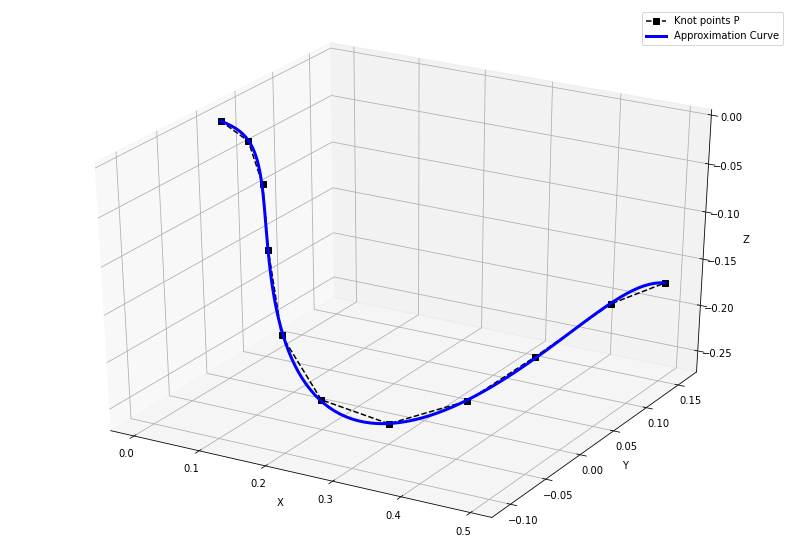

In [5]:
P = np.array([[ 0.  ,        0. ,         0.        ],
    [ 0.06037029, -0.01655962, -0.00596594],
    [ 0.11516818, -0.04656204, -0.02993338],
    [ 0.16245809, -0.08227048, -0.07386354],
    [ 0.20713518, -0.10636885, -0.14393959],
    [ 0.24660158, -0.09160223, -0.2126525 ],
    [ 0.28601963, -0.03657332, -0.26019828],
    [ 0.32568915,  0.03713823, -0.26640916],
    [ 0.36715515,  0.09548345, -0.24051881],
    [ 0.43088264,  0.14425904, -0.1962152 ],
    [ 0.49433236,  0.16003601, -0.17173643]])

R = parametric_fitting()
f_uu = R.run(P)


#--- 3D Plot
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.plot(*P.T, color='k', ls='--', marker='s', label='Knot points P')
ax.plot(*f_uu.T, color='b', ls='-', lw=3, label='Approximation Curve')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
# ax.set_aspect('equal', 'datalim')


plt.show()